# Import Libraries

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from imblearn.over_sampling import SMOTE

# Basic overview of the data

In [41]:
# Import datasets
train_df = pd.read_csv("csv_files/train.csv")
test_df = pd.read_csv("csv_files/test.csv")

print('Training dataset: ')
display(train_df.head(3))

print('Testing dataset: ')
display(test_df.head(3))

# Check for any duplicates
print(f"Duplicates in Train Dataset is:{train_df.duplicated().sum()},({100*train_df.duplicated().sum()/len(train_df)})%")
print(f"Duplicates in Test Dataset is:{test_df.duplicated().sum()},({100*test_df.duplicated().sum()/len(test_df)})%")


Training dataset: 


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


Testing dataset: 


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


Duplicates in Train Dataset is:0,(0.0)%
Duplicates in Test Dataset is:0,(0.0)%


In [42]:
# Calculate missing data statistics for the training set
train_missing = train_df.isnull().sum()[train_df.isnull().sum() > 0].to_frame().rename(columns={0: "Number of Missing Values (Train)"})
train_missing["% of Missing Values (Train)"] = round((100 * train_missing["Number of Missing Values (Train)"] / len(train_df)), 2)

# Calculate missing data statistics for the testing set
test_missing = test_df.isnull().sum()[test_df.isnull().sum() > 0].to_frame().rename(columns={0: "Number of Missing Values (Test)"})
test_missing["% of Missing Values (Test)"] = round((100 * test_missing["Number of Missing Values (Test)"] / len(test_df)), 2)

# Combine the statistics into a single DataFrame by joining on the index (feature names)
combined_missing = train_missing.join(test_missing, how='outer')

# Reset the index to turn the index (feature names) into a regular column
combined_missing.reset_index(inplace=True)
combined_missing.rename(columns={"index": "Feature"}, inplace=True)

# Display the combined DataFrame
display(combined_missing)


,Feature,Number of Missing Values (Train),% of Missing Values (Train),Number of Missing Values (Test),% of Missing Values (Test)
0,Age,179,2.06,91,2.13
1,Cabin,199,2.29,100,2.34
2,CryoSleep,217,2.50,93,2.17
3,Destination,182,2.09,92,2.15
4,FoodCourt,183,2.11,106,2.48
5,HomePlanet,201,2.31,87,2.03
6,Name,200,2.30,94,2.20
7,RoomService,181,2.08,82,1.92
8,ShoppingMall,208,2.39,98,2.29
9,Spa,183,2.11,101,2.36


In [43]:
print("cardinality of categorical features in training datasets is:")
print(train_df.select_dtypes(include="object").nunique())

print("\n","-"*70)

print("\nCardinality of categorical features in testing datsets is:")
print(test_df.select_dtypes(include="object").nunique())

cardinality of categorical features in training datasets is:
PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64

 ----------------------------------------------------------------------

Cardinality of categorical features in testing datsets is:
PassengerId    4277
HomePlanet        3
CryoSleep         2
Cabin          3265
Destination       3
VIP               2
Name           4176
dtype: int64


# Deeper exploration of the data

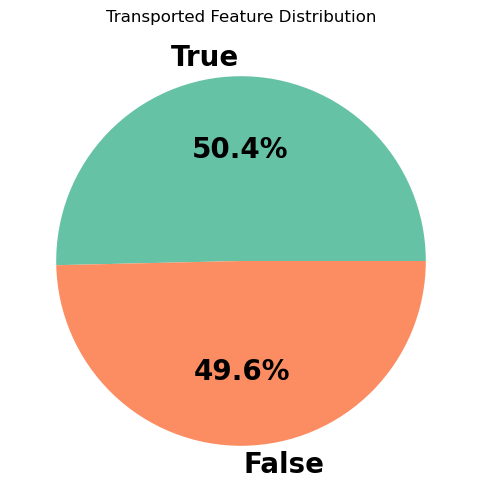

In [44]:
plt.figure(figsize=(10,6))
plt.pie(train_df["Transported"].value_counts(),labels=train_df["Transported"].value_counts().keys(),autopct="%1.1f%%",
       textprops={"fontsize":20,"fontweight":"black"},colors=sns.color_palette("Set2"))
plt.title("Transported Feature Distribution");

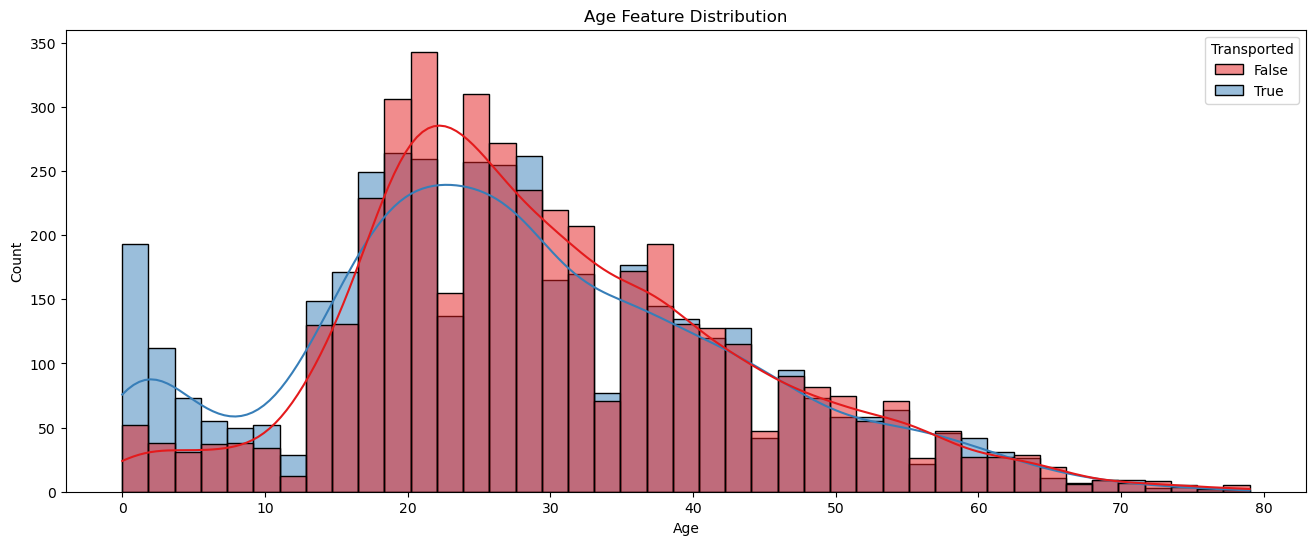

In [45]:
plt.figure(figsize=(16,6))
sns.histplot(x=train_df["Age"],hue="Transported",data=train_df,kde=True,palette="Set1")
plt.title("Age Feature Distribution");

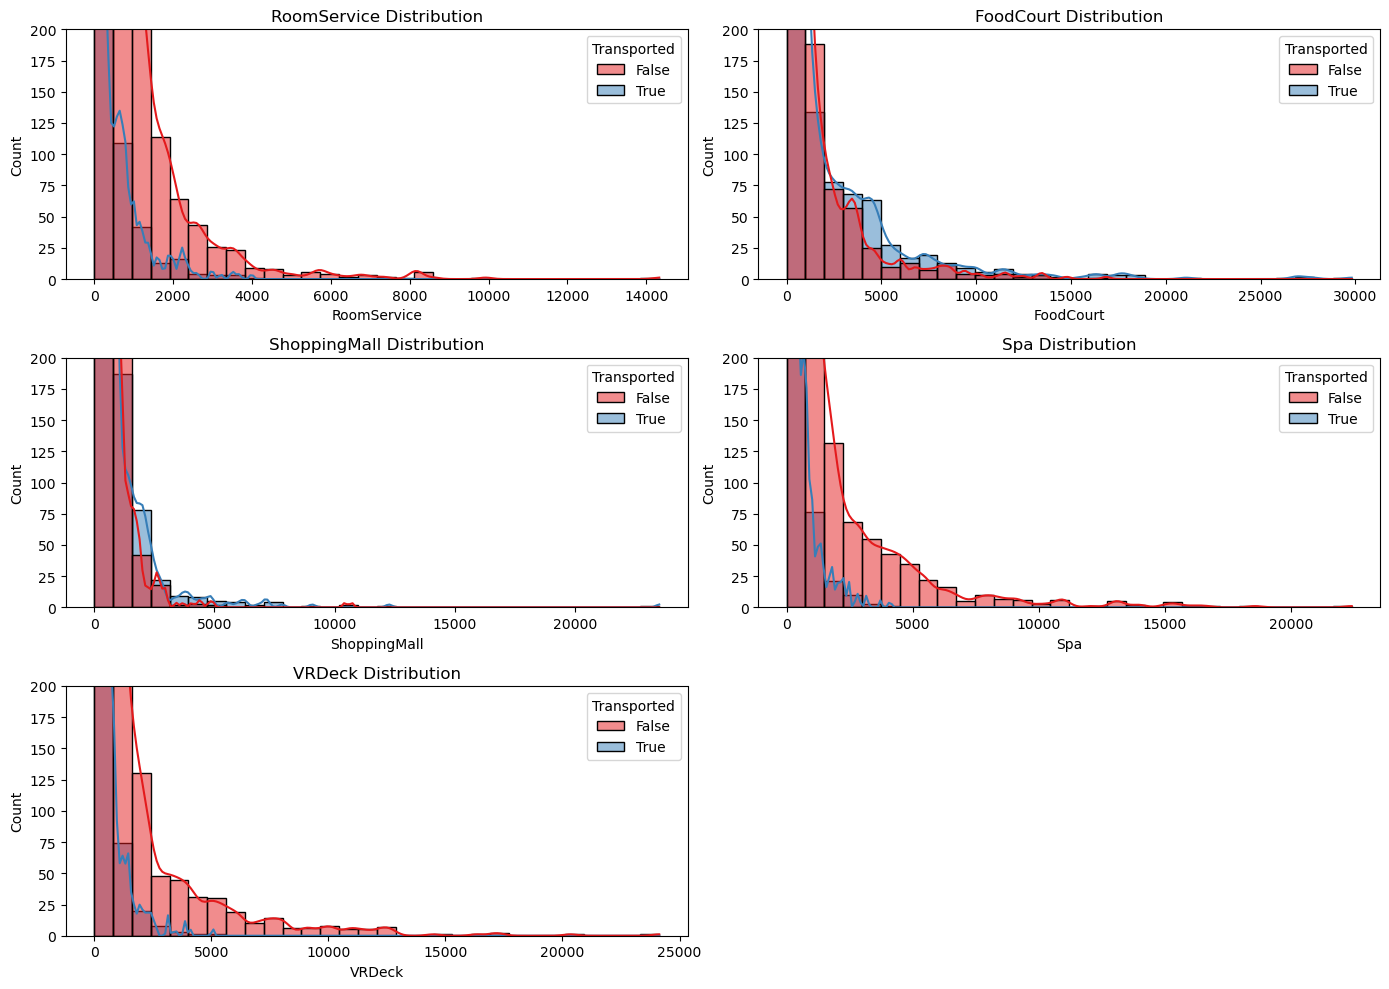

In [46]:
exp_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

plt.figure(figsize=(14,10))
for idx,column in enumerate(exp_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=column, hue="Transported", data=train_df,bins=30,kde=True,palette="Set1")
    plt.title(f"{column} Distribution")
    plt.ylim(0,200)
    plt.tight_layout()

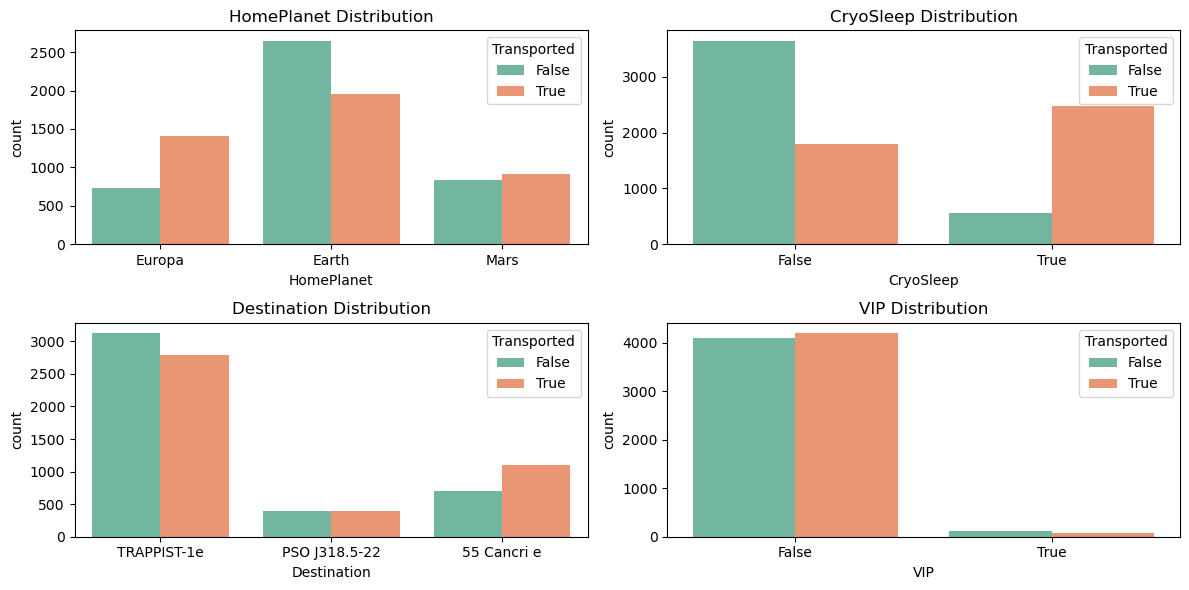

In [47]:
cat_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

# Create a 2x2 subplot grid and set the overall figure size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Iterate over the columns and the corresponding axes
for idx, column in enumerate(cat_cols):
    # Create a countplot for each categorical column on its respective axis
    sns.countplot(x=column, hue="Transported", data=train_df, palette="Set2", ax=axes_flat[idx])
    # Set the title for each subplot
    axes_flat[idx].set_title(f"{column} Distribution")

plt.tight_layout()
plt.show()


# Feature Engineering

In [48]:
def passengerid_new_features(df):
    
    #Splitting Group and Member values from "PassengerId" column.
    df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
    df["Member"] =df["PassengerId"].apply(lambda x: x.split("_")[1])
    
    #Grouping the "Group" feature with respect to "member" feature to check which group is travelling with how many members
    x = df.groupby("Group")["Member"].count().sort_values()
    
    #Creating a set of group values which are travelling with more than 1 members.
    y = set(x[x>1].index)
    
    #Creating a new feature "Solo" which will indicate whether the person is travelling solo or not.
    df["Travelling_Solo"] = df["Group"].apply(lambda x: x not in y)
    
    #Creating a new feature "Group_size" which will indicate each group number of members.
    df["Group_Size"]=0
    for i in x.items():
        df.loc[df["Group"]==i[0],"Group_Size"]=i[1]
    
    # Remove 'Group' and 'Member' as we got group size and travel solo
    df.drop(columns=["Group","Member"],inplace=True)

passengerid_new_features(train_df)
passengerid_new_features(test_df)

display(train_df.head(3))

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Travelling_Solo,Group_Size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,True,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,True,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,False,2


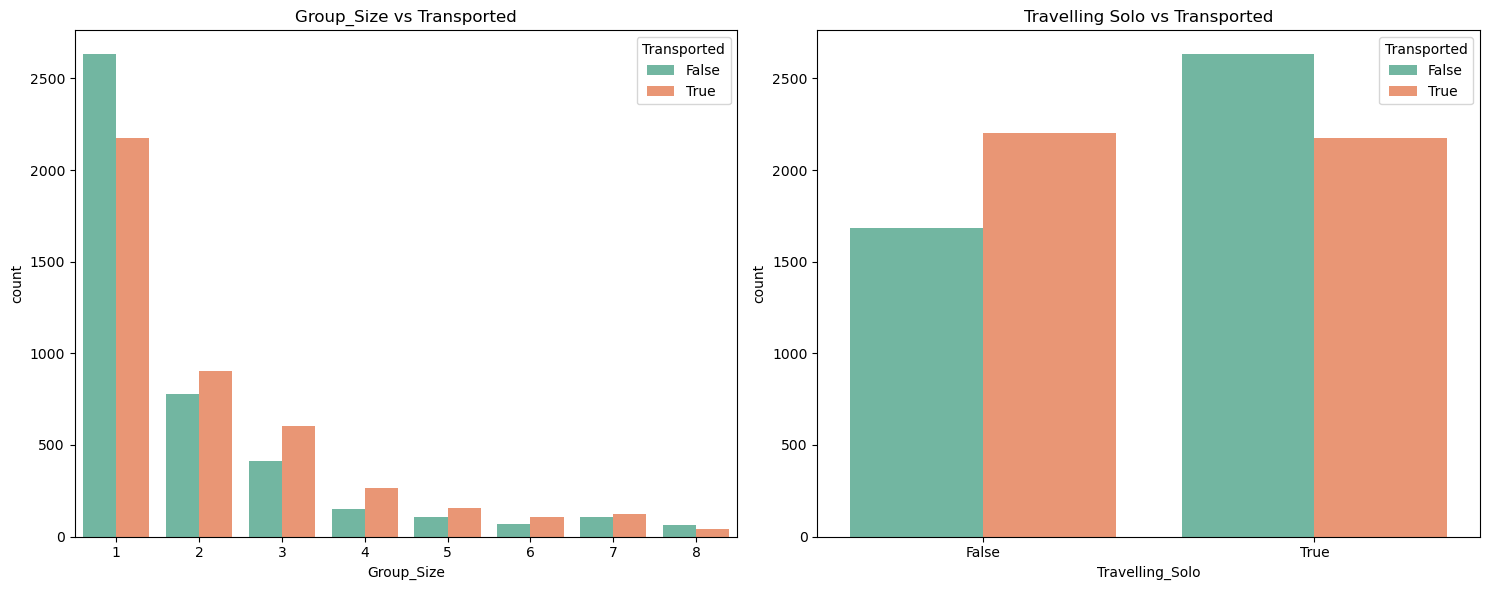

In [49]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.countplot(x="Group_Size", hue="Transported", data=train_df,palette="Set2")
plt.title("Group_Size vs Transported")

plt.subplot(1,2,2)
sns.countplot(x="Travelling_Solo", hue="Transported", data=train_df,palette="Set2")
plt.title("Travelling Solo vs Transported")
plt.tight_layout()
plt.show()

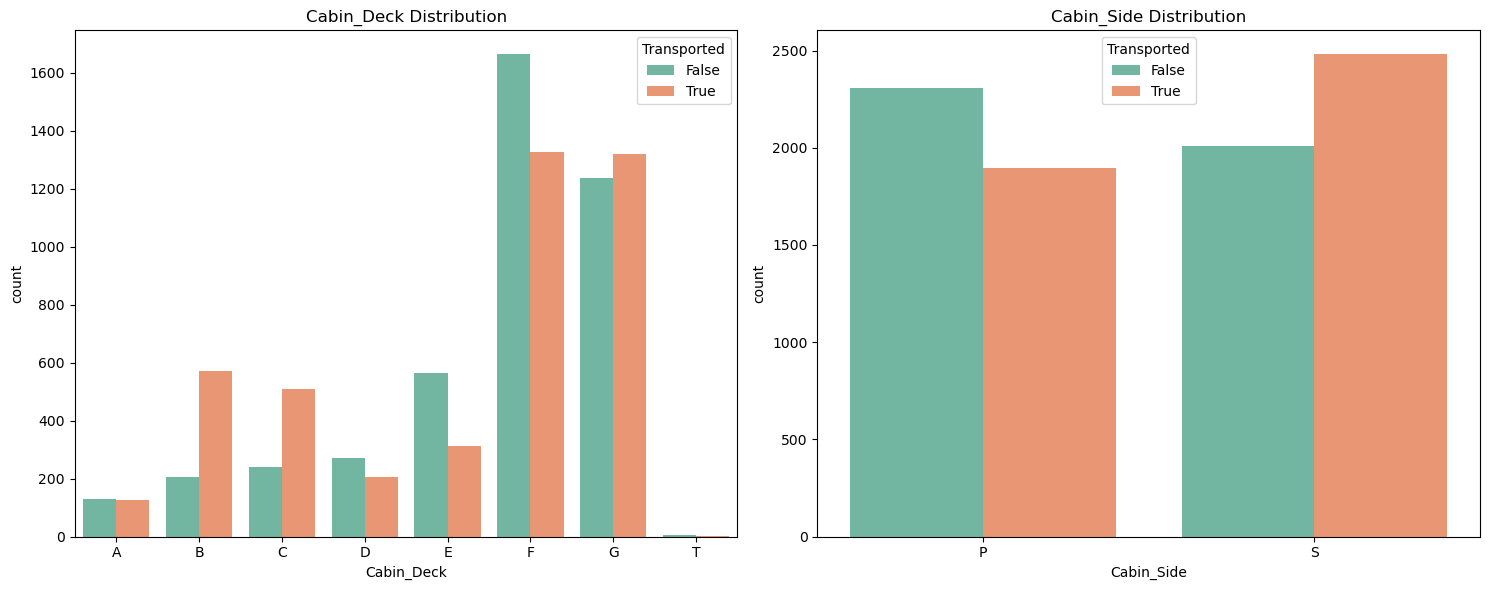

In [50]:
def cabin_new_feature(df):
    # Temporarily fill NaNs in 'Cabin' to facilitate splitting
    df["Cabin"].fillna("Unknown/Unknown/Unknown", inplace=True)
    
    # Split 'Cabin' into new features
    df["Cabin_Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["Cabin_Number"] = df["Cabin"].apply(lambda x: x.split("/")[1])
    df["Cabin_Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])
    
    # Replace 'Unknown' with np.nan to facilitate numerical operations and maintain consistency
    cols = ["Cabin_Deck", "Cabin_Number", "Cabin_Side"]
    df[cols] = df[cols].replace("Unknown", np.nan)
    
    # Convert 'Cabin_Number' to numeric, errors='coerce' will convert non-numeric to NaN
    df["Cabin_Number"] = pd.to_numeric(df["Cabin_Number"], errors='coerce')
    
    # Fill missing values in new features
    df["Cabin_Deck"].fillna(df["Cabin_Deck"].mode()[0], inplace=True)
    df["Cabin_Side"].fillna(df["Cabin_Side"].mode()[0], inplace=True)
    df["Cabin_Number"].fillna(df["Cabin_Number"].median(), inplace=True)

cabin_new_feature(train_df)
cabin_new_feature(test_df)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x="Cabin_Deck",hue="Transported", data=train_df, palette="Set2",order=["A","B","C","D","E","F","G","T"])
plt.title("Cabin_Deck Distribution")

plt.subplot(1,2,2)
sns.countplot(x="Cabin_Side", hue="Transported", data=train_df, palette="Set2")
plt.title("Cabin_Side Distribution")
plt.tight_layout()
plt.show()

Total Unique values present in Cabin_Number feature is: 1817
The Mean of Cabin_Number Feature is:  596.3989416772115
The Median of Cabin_Number Feature is: 427.0
The Minimum value of Cabin_Number feature is: 0
The Maximum value of Cabin_number Feature is: 1894


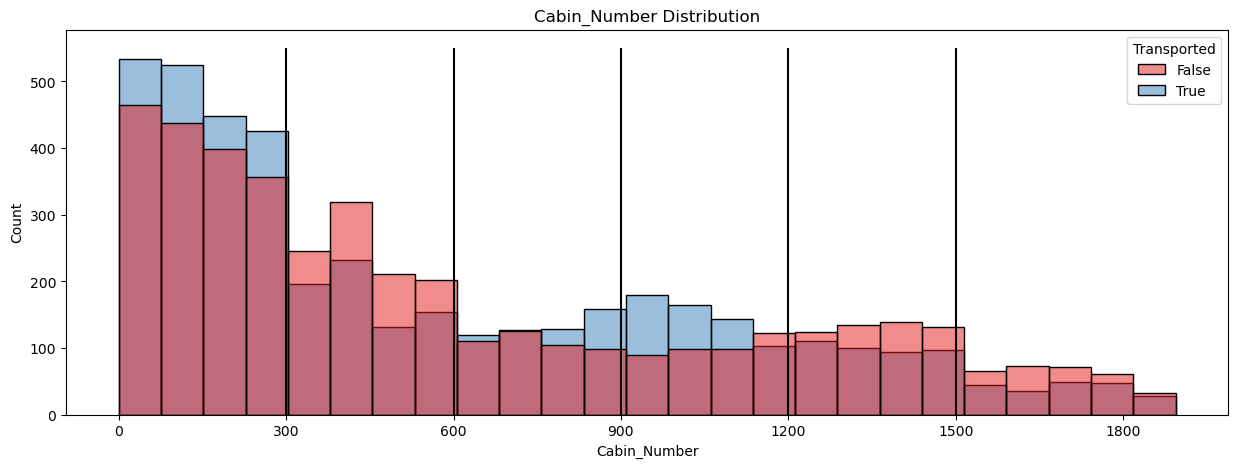

In [51]:
train_df["Cabin_Number"]=train_df["Cabin_Number"].astype(int)
test_df["Cabin_Number"]=test_df["Cabin_Number"].astype(int)

print("Total Unique values present in Cabin_Number feature is:",train_df["Cabin_Number"].nunique())
print("The Mean of Cabin_Number Feature is: ",train_df["Cabin_Number"].mean())
print("The Median of Cabin_Number Feature is:",train_df["Cabin_Number"].median())
print("The Minimum value of Cabin_Number feature is:",train_df["Cabin_Number"].min())
print("The Maximum value of Cabin_number Feature is:",train_df["Cabin_Number"].max())

plt.figure(figsize=(15,5))
sns.histplot(x="Cabin_Number",data=train_df,hue="Transported",palette="Set1")
plt.title("Cabin_Number Distribution")
plt.xticks(list(range(0,1900,300)))
plt.vlines(300,ymin=0,ymax=550,color="black")
plt.vlines(600,ymin=0,ymax=550,color="black")
plt.vlines(900,ymin=0,ymax=550,color="black")
plt.vlines(1200,ymin=0,ymax=550,color="black")
plt.vlines(1500,ymin=0,ymax=550,color="black")
plt.show()

In [52]:
def cabin_regions(df):
    df["Cabin_Region1"] = (df["Cabin_Number"]<300)
    df["Cabin_Region2"] = (df["Cabin_Number"]>=300) & (df["Cabin_Number"]<600)
    df["Cabin_Region3"] = (df["Cabin_Number"]>=600) & (df["Cabin_Number"]<900)
    df["Cabin_Region4"] = (df["Cabin_Number"]>=900) & (df["Cabin_Number"]<1200)
    df["Cabin_Region5"] = (df["Cabin_Number"]>=1200) & (df["Cabin_Number"]<1500)
    df["Cabin_Region6"] = (df["Cabin_Number"]>=1500)

    df.drop(columns=["Cabin_Number"],inplace=True)

cabin_regions(train_df)
cabin_regions(test_df)


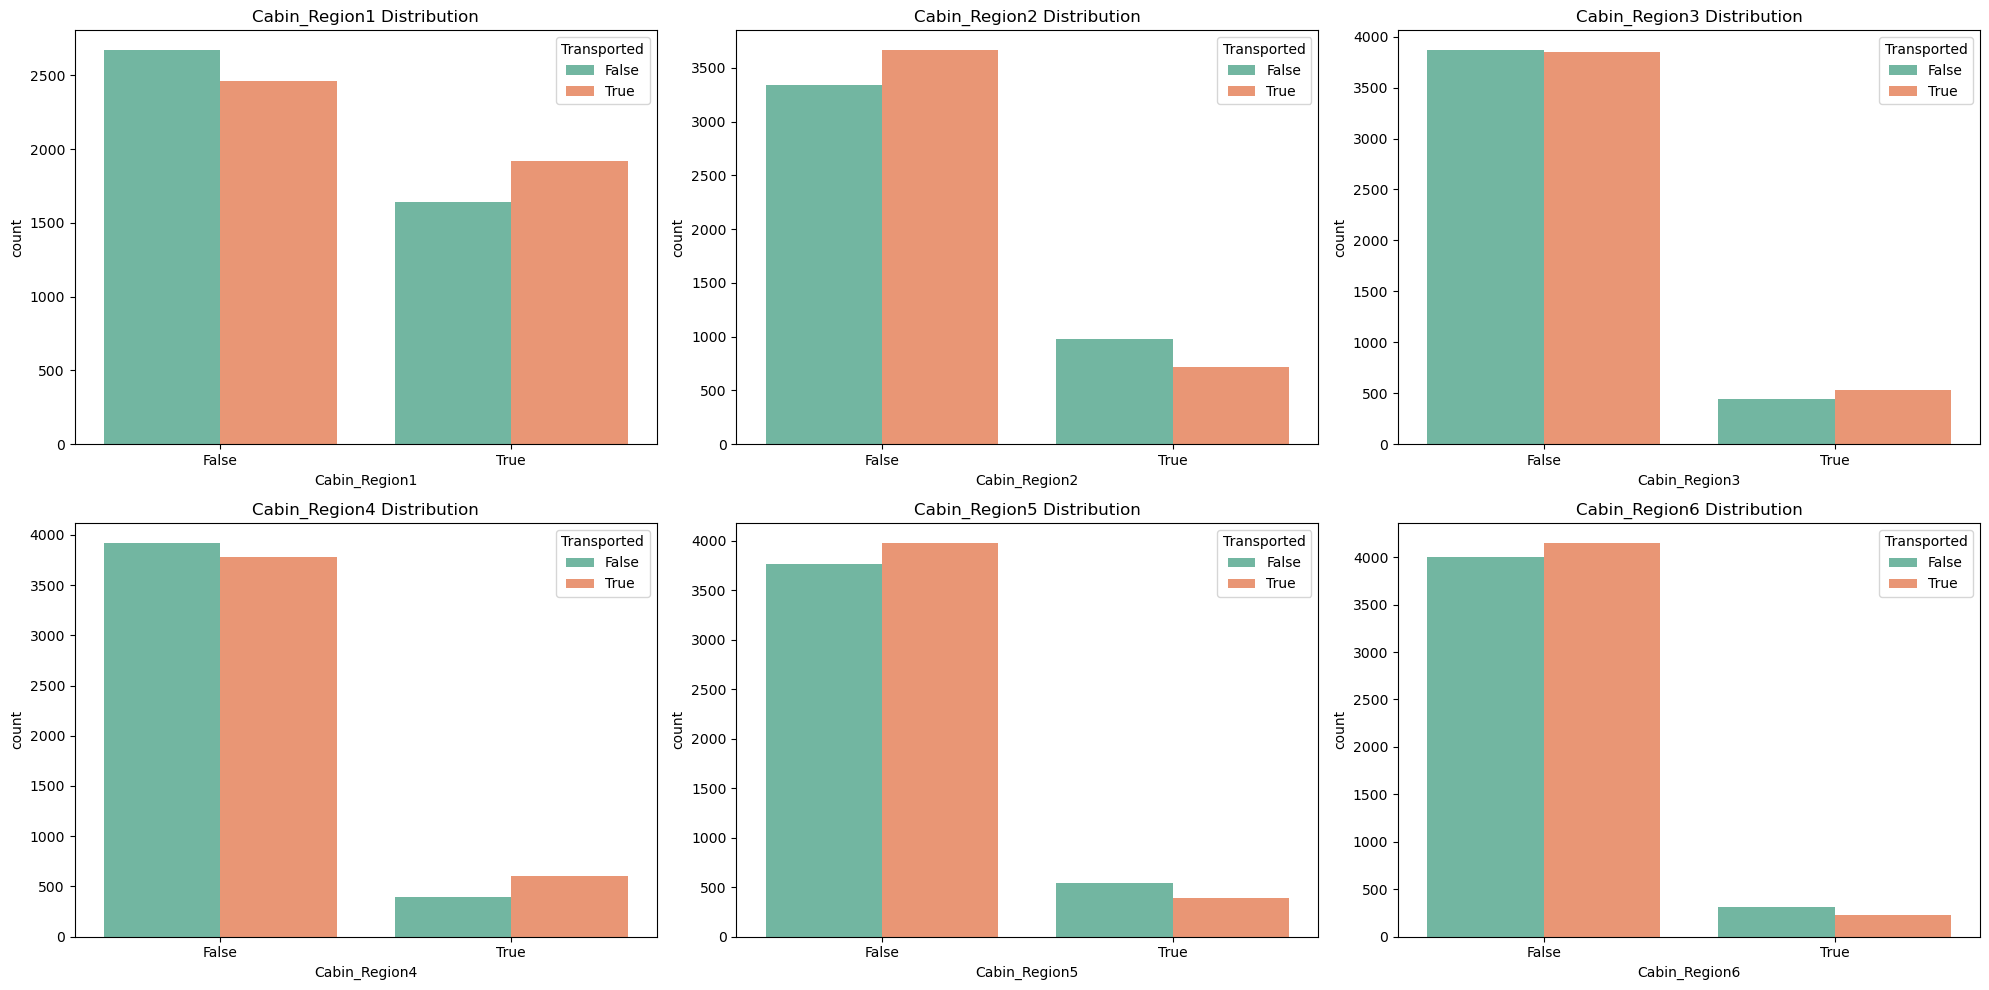

In [57]:
cols = ["Cabin_Region1","Cabin_Region2","Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6"]

plt.figure(figsize=(20,10))

for idx,value in enumerate(cols):
    plt.subplot(2,3,idx+1)
    sns.countplot(x=value, hue="Transported", data=train_df, palette="Set2")
    plt.title(f"{value} Distribution")
    plt.tight_layout()

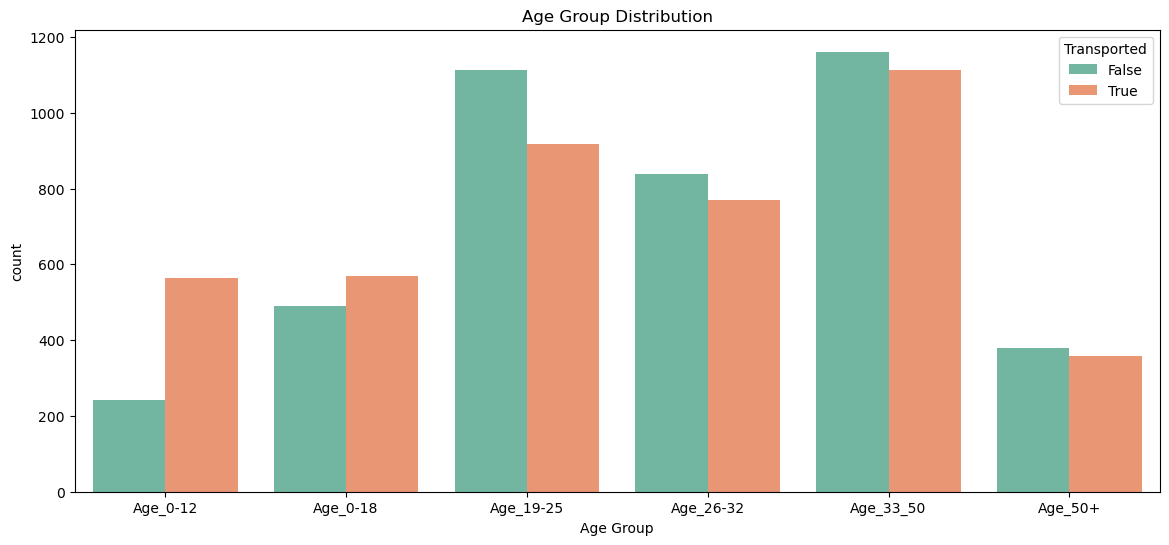

In [59]:
def age_group(df):
    age_group  = []
    for i in df["Age"]:
        if i<=12:
            age_group.append("Age_0-12")
        elif (i>12 and i<=18):
            age_group.append("Age_0-18")
        elif (i>18 and i<=25):
            age_group.append("Age_19-25")
        elif (i>25 and i<=32):
            age_group.append("Age_26-32")
        elif (i>32 and i<=50):
            age_group.append("Age_33_50")
        elif (i>50):
            age_group.append("Age_50+")
        else:
            age_group.append(np.nan)
        
    df["Age Group"] = age_group

age_group(train_df)
age_group(test_df)

order = sorted(train_df["Age Group"].value_counts().keys().to_list())

plt.figure(figsize=(14,6))
sns.countplot(x="Age Group",hue="Transported", data=train_df, palette="Set2",order=order)
plt.title("Age Group Distribution");